In [1]:
import glob
import os
import os.path as op
import sys
from collections import OrderedDict
from collections.abc import Callable
from typing import Literal, Optional

import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch import Tensor

import plenoptic as po
from plenoptic.synthesize.metamer import MetamerCTF
from plenoptic.tools import optim

sys.path.append("../src/plenoptic/tools/")
from plenoptic.tools import img_transforms

%load_ext autoreload
%autoreload 

# We need to download some additional images for this notebook. In order to do so,
# we use an optional dependency, pooch. If the following raises an ImportError or ModuleNotFoundError
# then install pooch in your plenoptic environment and restart your kernel.
DATA_PATH = po.data.fetch_data("portilla_simoncelli_images.tar.gz")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

# set seed for reproducibility
po.tools.set_seed(1)

In [2]:
# These variables control how long metamer synthesis runs for. The values present here will result in completed synthesis,
# but you may want to decrease these numbers if you're on a machine with limited resources.
short_synth_max_iter = 10
long_synth_max_iter = 300
longest_synth_max_iter = 10000

# Portilla-Simoncelli Texture Metamer

In this tutorial we will aim to replicate [Portilla & Simoncelli (1999)](https://www.cns.nyu.edu/pub/eero/portilla99-reprint.pdf). The tutorial is broken into the following parts:

1. Introduce the concept of a Visual Texture.
2. How to synthesize metamers for the Portilla & Simoncelli texture model. 
3. Demonstrate the importance of different classes of statistics.
4. Extending the model to synthesizing color metamers


Note that this notebook takes a long time to run (roughly an hour with a GPU, several hours without), because of all the metamers that are synthesized.

## 1. What is a visual texture?

The simplest definition is a repeating visual pattern. Textures encompass a wide variety of images, including natural patterns such as bark or fur, artificial ones such as brick, and computer-generated ones such as the Julesz patterns ([Julesz 1978](https://link.springer.com/article/10.1007/BF00336998), [Yellot 1993](https://opg.optica.org/josaa/abstract.cfm?uri=josaa-10-5-777)). Below we load some examples.  

The Portilla-Simoncelli model was developed to measure the statistical properties of visual textures.  Metamer synthesis was used (and can be used) in conjunction with the Portilla-Simoncelli texture model to demonstrate the necessity of different properties of the visual texture.  We will use some of these example textures to demonstrate aspects of the Portilla Simoncelli model.

In [3]:
# For the remainder of the notebook we will use this helper function to
# run synthesis so that the cells are a bit less busy.

# Be sure to run this cell.

# path to the data: /mnt/home/hdettki/ceph/Datasets/select_color_textures_unsplash
# path to color script: /mnt/home/hdettki/code/plenoptic/src/plenoptic/synthesize


def run_synthesis(
    img,
    model,
    loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    im_init=None,
):
    r"""Performs synthesis with the full Portilla-Simoncelli model.

    Parameters
    ----------
    img : Tensor
        A tensor containing an img.
    model :
        A model to constrain synthesis.
    im_init: Tensor
        A tensor to start image synthesis.

    Returns
    -------
    met: Metamer
        Metamer from the full Portilla-Simoncelli Model

    """
    if im_init is None:
        im_init = torch.rand_like(img) * 0.01 + img.mean()
    met = po.synth.MetamerCTF(
        img,
        model,
        loss_function=loss_function,
        initial_image=im_init,
        coarse_to_fine="together",
    )
    met.synthesize(
        max_iter=short_synth_max_iter,
        store_progress=True,
        change_scale_criterion=None,
        ctf_iters_to_check=4,  # todo: tinker with this
    )
    return met

## 2. Using the Portilla-Simoncelli Model to Compute Realistic Color Metamers

Before adapting the model to synthesize metamers better on color texture images, let's have a look at the existing model's behavior.

### Combining Channel Information in RGB-Images
- The current implementation of the Portilla-Simoncelli Model computes the statistics on all channels separately, i.e., treats each channel as a separate image, resulting in unrealistic metamers (see demo below).
- This is why we will play around with color transforms in the forward method.
- We will first mmic what [Brown 2023](https://dl.acm.org/doi/full/10.1145/3564605#sec-supp) et al. did.
- In particular, we will write our custom Portilla-Simoncelli class, where we do the following steps:

#### Implementation:
0. **Transform to LMS**:
    - transform RGB to an LMS-like space, then from that into opposing color channels (define rgb2opc)
1. **Channel Separation**: The input image is split into its constituent channels.
    - compute L2 loss separately on each channel, the use torch.logsumexp to comine them
2. **Independent Processing**: Each channel is processed independently to compute the relevant statistics.
    - then add cross-channel correlations as in Brown
3. **Normalization and Weighting**: The computed statistics are normalized and weighted to ensure they contribute appropriately to the final representation. E.g., the green channel might be assigned higher weights as it  is often more sensitive in human vision.
4. **Fusion and Integration**: The normalized and weighted statistics are combined to form the final multi-channel representation.

### Synthesis on Color-Texture Images
#### Load Images

In [4]:
path_to_unsplash = "../../../ceph/Datasets/select_color_textures_unsplash"

In [5]:
# import select color images

# Step 1: Check if the path to the images exists
# You can specify the extensions of the images you want to load, e.g., *.jpg, *.png, etc.
image_files = glob.glob(
    os.path.join(path_to_unsplash, "*.jpg")
)  # Assuming images are in .jpg format
image_files.extend(
    glob.glob(os.path.join(path_to_unsplash, "*.png"))
)  # Include .png format as well

# Step 2: Load the images
images = []
for image_file in image_files:
    try:
        img = Image.open(image_file)
        images.append(img)
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")
# po.imshow(po.tools.load_images(path_to_unsplash, as_gray=False), as_rgb=True)

In [6]:
# transform the images to tensors and then resize them to 256x256
# images = [torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0).float() / 255.0 for img in images]
# Define a sequence of transformations
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),  # resize to 256x256
        transforms.ToTensor(),  # Convert to tensor
    ]
)

# Apply the transformations
img_tensor_ls = []
for img in images:
    img_tensor_ls.append(transform(img))

img_tensor = torch.stack(
    img_tensor_ls, dim=0
)  # stack the images along the batch dimension
# send images to GPU, if available
img_tensor = img_tensor.to(DEVICE)

#### 1. Synthesis with Original Model

In [7]:
# for each image, run synthesis with full PortillaSimoncelli model
# model = po.simul.PortillaSimoncelli(img_tensor.shape[-2:]).to(DEVICE)
# metamers = []
# for i in range(img_tensor.shape[0]):
#     # metamer = run_synthesis(img_tensor[i:i+1], model)
#     metamer = run_synthesis(img_tensor[i:i+1], model,loss_function=po.tools.optim.l2_norm)
#     metamers.append(metamer)
# # print the metamer images
# po.imshow([metamer.image for metamer in metamers], title='Target images', as_rgb=True)
# # print target image
# po.imshow([metamer.metamer for metamer in metamers], title='Synthesized metamer images', as_rgb=True)


Clearly, the above metamers show some discrepancies to the target image, some more, some less. While images 2, 3, and 4 approximate the texture of the target image quite well, the colors are a bit off, especially in image 4. Metamers 1 and 5 are off in both color and texture. It seems that homegeneous, finer patterns are well represented by the model, while distinct coarser structures, such as the arteries in the leaves or the cracks in the wood, are captured, but not in the same location. The result is a combined texture that doesn't reflect the original in the physical world. 

So let's, first tweak the model so that it performs better in terms of color in the metamers.

#### 2. Adapting the Model to Produce Better Color Metamers
**Combining Channel Information in RGB-Images**
- The current implementation of the Portilla-Simoncelli Model computes the statistics on all channels separately, i.e., treats each channel as a separate image, resulting in unrealistic metamers (see demo below).
- This is why we will play around with color transforms in the forward method.
- We will first mmic what [Brown 2023](https://dl.acm.org/doi/full/10.1145/3564605#sec-supp) et al. did.
- In particular, we will write our custom Portilla-Simoncelli class, where we do the following steps:

##### Implementation:
0. **Transform to LMS**:
    - transform RGB to an LMS-like space, then from that into opposing color channels (define rgb2opc)
    - Most of the color transforms are copied from color_utils.py in [PooledStatisticsMetamers](https://github.com/ProgramofComputerGraphics/PooledStatisticsMetamers/blob/main/poolstatmetamer/color_utils.py#L58) repo 
1. **Channel Separation**: The input image is split into its constituent channels.
    - compute L2 loss separately on each channel, the use torch.logsumexp to comine them
2. **Independent Processing**: Each channel is processed independently to compute the relevant statistics.
    - then add cross-channel correlations as in Brown
3. **Normalization and Weighting**: The computed statistics are normalized and weighted to ensure they contribute appropriately to the final representation. E.g., the green channel might be assigned higher weights as it  is often more sensitive in human vision.
4. **Fusion and Integration**: The normalized and weighted statistics are combined to form the final multi-channel representation.

#### Image transformations
- rgb to lms to opc
- leads to big improvement in colors of metamers

In [8]:
# let's first take care of the transforms
# A approximate transform from a typical RGB space to cone LMS space
# Would be good to check this to see if is a reasonable default approximation for
# human cone LMS, but results so far don't seem to depend much on precise color transform details
# code largely copied from color_utils in PooledStatisticsMetamers repo
# rgb2lms = torch.tensor([[0.3811, 0.5783, 0.0402],
#                         [0.1967, 0.7244, 0.0782],
#                         [0.0241, 0.1288, 0.8444]])
# lms2rgb = torch.inverse(rgb2lms)
# # A simple approximation of the opponent cone color space (achromatic,red-green,blue-yellow)
# # I also scaled their magnitudes to make the channels have more simlar ranges
# lms2opc = torch.tensor([[0.5, 0.5, 0],    # (L+M) / 2)
#                        [-4, 4, 0],        # (M-L) * 3
#                        [0.5, 0.5, -1]])  # (L+M)/2 - S)

# opc2lms = lms2opc.inverse()

# # Composite transform from RGB to cone-opponent color space
# rgb2opc = torch.matmul(lms2opc,rgb2lms)

# opc2rgb = rgb2opc.inverse()

# # Short names for the three opponent channels, short for (achromatic,red-green,blue-yellow)
# opc_short_names = ('ac','rg','by')


# # Apply the specified color tranformation matrix to an image
# def color_transform_image(image,color_matrix):
#     if image.dim()==3:
#         return torch.nn.functional.conv2d(image[None,:,:,:],color_matrix[:,:,None,None])
#     else:
#         return torch.nn.functional.conv2d(image,color_matrix[:,:,None,None])


# # Convert an RGB image to cone LMS image
# def rgb_to_coneLMS(image):
#     return color_transform_image(image,rgb2lms)

# # Convert an RGB image to a cone opponent space image
# def rgb_to_opponentcone(image):
#     return color_transform_image(image,rgb2opc)

# def rescale(image: torch.Tensor, range: tuple = (0, 1)):
#     # Compute the min and max values across height and width for each image in the batch
#     min_val = image.amin(dim=(2, 3), keepdim=True)
#     max_val = image.amax(dim=(2, 3), keepdim=True)

#     # Rescale the images to the range [0, 1]
#     image = (image - min_val) / (max_val - min_val + 1e-8)  # Adding epsilon to avoid division by zero

#     return image, min_val, max_val
# def inverse_rescale(image: torch.Tensor, min_val: torch.Tensor, max_val: torch.Tensor):
#     # Reverse the rescaling to original values
#     image = image * (max_val - min_val) + min_val
#     return image

#### Test on a single image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22439216..0.7822289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.082353..1.3647059].


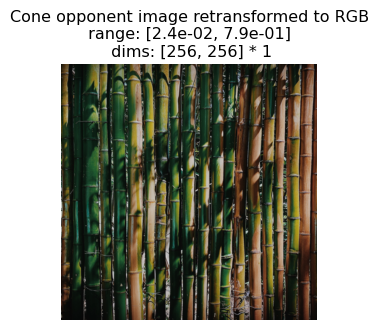

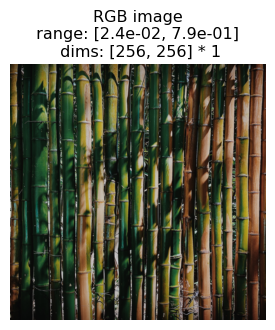

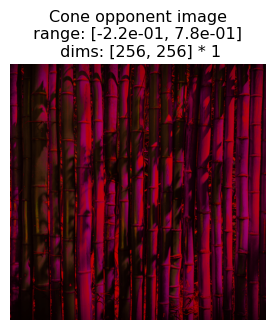

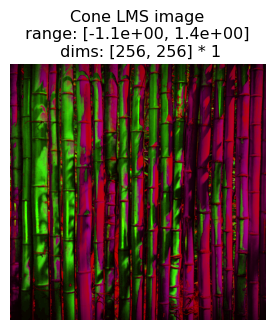

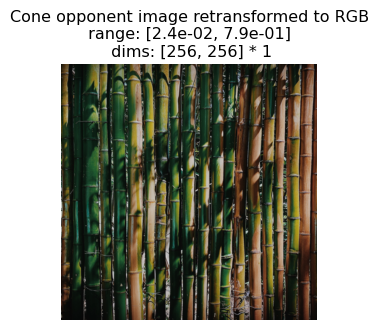

In [9]:
# test on a single image
# Single wood image
wood_img = img_tensor[0].unsqueeze(dim=0).to("cpu")
opc_image = einops.einsum(
    wood_img, img_transforms.rgb2opc, "b c1 h w, c2 c1 -> b c2 h w"
)  # tensor product of image and color matrix
lms_images = einops.einsum(
    wood_img, img_transforms.lms2opc, "b c1 h w, c2 c1 -> b c2 h w"
)  # tensor product of image and color matrix

# transform opc image to rgb
opc_image_retransf = einops.einsum(
    opc_image, img_transforms.opc2rgb, "b c1 h w, c2 c1 -> b c2 h w"
)
po.imshow(wood_img, title="RGB image", as_rgb=True)
po.imshow(opc_image, title="Cone opponent image", as_rgb=True)
po.imshow(lms_images, title="Cone LMS image", as_rgb=True)
po.imshow(
    opc_image_retransf, title="Cone opponent image retransformed to RGB", as_rgb=True
)

#### test on entire image batch
- first transform images to opc space
- then run synthesis
- re-transform to rgb and re-scale

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22439216..0.7822289].


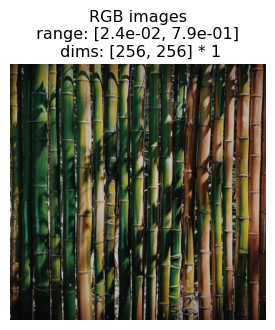

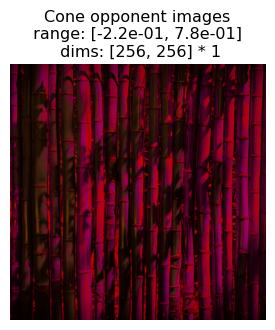

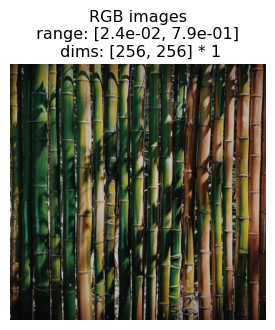

In [10]:
# Check if CUDA is available and move tensors to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move img_tensor and rgb2opc to the chosen device
img_tensor = img_tensor.to(device)
# only select first image
img_tensor = img_tensor[0:1]


# Convert the images to cone opponent space
img_opc_tensor = img_transforms.color_transform_image(
    img_tensor, img_transforms.rgb2opc.to(device)
)
po.imshow(img_opc_tensor, title="Cone opponent images", as_rgb=True)
po.imshow(img_tensor, title="RGB images", as_rgb=True)
# convert img_tensor to black and white

In [11]:
# Compute rescaled images and min/max values
img_opc_tensor_rescaled, min_val, max_val = img_transforms.rescale(img_opc_tensor)
img_opc_tensor_resc_inv = img_transforms.inverse_rescale(
    img_opc_tensor_rescaled, min_val, max_val
)
# Sanity check: the original and rescaled images should be the same
# Check if the inverse rescaling works correctly
torch.allclose(img_opc_tensor, img_opc_tensor_resc_inv, atol=1e-6)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22439216..0.7822289].


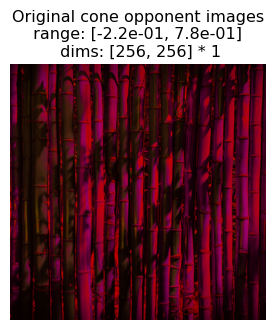

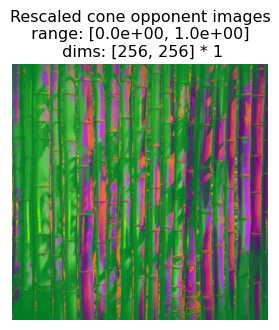

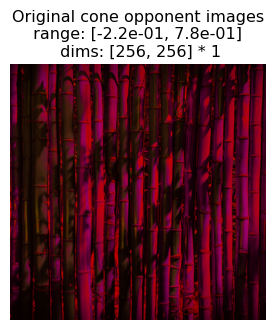

In [12]:
# show the rescaled opc images
po.imshow(img_opc_tensor_rescaled, title="Rescaled cone opponent images", as_rgb=True)
# show the original opc images
po.imshow(img_opc_tensor, title="Original cone opponent images", as_rgb=True)
# Sanity check: the original and rescaled images should be the same
# show the inverse rescaled opc images
# po.imshow(img_opc_tensor_resc_inv, title='Inverse rescaled cone opponent images', as_rgb=True)

In [13]:
# error because only one image in the batch for metamer synthesis for testing purposes
# plotting code below should work

# plot histogram for each image in the batch of rescaled images
def plot_histograms(images: torch.Tensor, title: str, bins: int = 100):
    # Ensure images are on CPU and converted to numpy arrays
    images_np = images.cpu().numpy()

    # Create a figure and axis
    fig, axs = plt.subplots(
        images.shape[0], images.shape[1], figsize=(21, 9), sharex=True
    )
    fig.suptitle(title)

    # Plot the histograms for each channel of each image in the batch
    for i in range(images.shape[0]):  # iterate over images
        for j in range(images.shape[1]):  # iterate over channels
            axs[i, j].hist(images_np[i, j].flatten(), bins=bins)
            axs[i, j].set_title(f"Image {i + 1}, Channel {j + 1}")
            axs[i, j].set_xlabel("Pixel Intensity")
            axs[i, j].set_ylabel("Frequency")
    # plt.tight_layout()
    plt.show()


# histograms of the rgb images
# plot_histograms(img_tensor, title="Histograms of RGB Images")
#  histograms of the opc images prio to rescaling
# plot_histograms(img_opc_tensor, title="Histograms of Cone Opponent Images")
#  histograms of the rescaled images
# plot_histograms(
#     img_opc_tensor_rescaled, title="Histograms of Rescaled Cone Opponent Images"
# )
# print the min and max value for each image in the batch of rescaled images, opc images and rgb images

### custom Loss function
- compute the L2 norm on each channel separately 
- then combine channel losses with logsumexp

In [14]:
# def l2_channelwise(synth_rep: torch.Tensor, ref_rep: torch.Tensor, **kwargs) -> torch.Tensor:
#     r"""l2-norm of the difference between ref_rep and synth_rep per channel.

#     Parameters
#     ----------
#     synth_rep
#         The first tensor to compare, model representation of the
#         synthesized image.
#     ref_rep
#         The second tensor to compare, model representation of the
#         reference image. must be same size as ``synth_rep``.
#     kwargs
#         Ignored, only present to absorb extra arguments.

#     Returns
#     -------
#     loss
#         The L2-norm of the difference between ``ref_rep`` and ``synth_rep``.

#     """
#     channel_losses = torch.linalg.vector_norm(ref_rep - synth_rep, dim=2,ord=2)
#     # print(f'channel losses {channel_losses}, channel loss shape: {channel_losses.shape}')
#     return torch.logsumexp(channel_losses, dim=1)

## Cross-channel statistis in Portilla-Simoncelli Class

In [15]:
"""The following class tweaks the PortillaSimoncelli model so that it will process color
 images better.
  In particular, we introduce cross-color channel statistics, to capture the 
  relationship between different color channels.
 The cross-color statistics are a reduced set of statistis, currently only 
 encompassing covariance/correlation.
"""

SCALES_TYPE = Optional[list[int]]


# from collections import OrderedDict
class PortillaSimoncelliCrossChannel(po.simul.PortillaSimoncelli):
    r"""Model for measuring a subset of texture statistics reported by PortillaSimoncelli

    Parameters
    ----------
    im_shape: int
        the size of the images being processed by the model, should be divisible by
          2^n_scales
    remove_keys: list
        The dictionary keys for the statistics we will "remove".  In practice we set
        them to zero.
        Possible keys: ["pixel_statistics", "auto_correlation_magnitude",
        "skew_reconstructed", "kurtosis_reconstructed",
        "auto_correlation_reconstructed",
        "std_reconstructed", "magnitude_std", "cross_orientation_correlation_magnitude",
        "cross_scale_correlation_magnitude" "cross_scale_correlation_real",
        "var_highpass_residual"]
    """

    def __init__(
        self,
        im_shape,
        scale_ch_covar: float,
        scale_cor_mag: float,
        scale_cor_real: float,
    ):
        super().__init__(im_shape, n_scales=4, n_orientations=4, spatial_corr_width=9)
        self.scale_ch_covar = scale_ch_covar
        self.scale_cor_mag = scale_cor_mag
        self.scale_cor_real = scale_cor_real

    def forward(
        self, image: torch.Tensor, scales: list[SCALES_TYPE] | None = None
    ) -> torch.Tensor:
        """
        Generate Texture Statistics representation of an image with cross-channel
        statistics.

        Parameters
        ----------
        image : Tensor
            A 4d tensor (batch, channel, height, width) containing the image(s) to
            analyze.
        scales : List[SCALES_TYPE], optional
            Which scales to include in the returned representation. If None, include
            all scales.

        Returns
        -------
        representation_tensor : Tensor
            3d tensor of shape (batch, channel, stats) containing the measured texture
            statistics.

        Raises
        ------
        ValueError
            If `image` is not 4d or has a dtype other than float or complex.
        """

        # call the parent class forward method to compute the base statistics
        base_representations = super().forward(image, scales=scales)

        # compute the cross-channel statistics
        cross_channel_stats_img = self._compute_cross_channel_covariance4D(image)

        pyr_dict, pyr_coeffs, highpass, _ = self._compute_pyr_coeffs(image)
        mag_pyr_coeffs, real_pyr_coeffs = self._compute_intermediate_representations(
            pyr_coeffs
        )

        # cross channel correlation for magnitude coefficients in the pyramid
        # first convert list of magnitudes to a tensor
        # mag_pyr_coeffs_tensor = torch.cat(mag_pyr_coeffs, dim=2) # stack along
        # scales dimension -> doesn't work since H and W are different for each tensor
        # in list
        cross_channel_correlation_magnitude = []

        for mag_pyr_coeff in mag_pyr_coeffs:
            print(f"magnitude pyramid coefficient shape: {mag_pyr_coeff.shape}")
            cross_channel_correlation_magnitude.append(
                self._compute_cross_channel_correlation5D(mag_pyr_coeff)
            )

        # cross channel correlation for real pyramid coefficients
        cross_channel_correlation_real = []
        for real_pyr_coeff in real_pyr_coeffs:
            print(f"real pyramid coefficient shape: {real_pyr_coeff.shape}")
            cross_channel_correlation_real.append(
                self._compute_cross_channel_correlation5D(real_pyr_coeff)
            )

        # turn list of tensors into a single tensor
        cross_channel_correlation_magnitude_t = torch.cat(
            cross_channel_correlation_magnitude, dim=1
        )

        # add a singleton dimension at the beginning
        cross_channel_correlation_magnitude_t = cross_channel_correlation_magnitude_t[
            None, ...
        ]

        cross_channel_correlation_real_t = torch.cat(
            cross_channel_correlation_real, dim=1
        )
        # add a singleton dimension at the beginning
        cross_channel_correlation_real_t = cross_channel_correlation_real_t[None, ...]

        # padded_real_pyramid_covar = torch.cat(padded_real_pyramid_covar_list, dim=1)

        # padded_mag_pyramid_covar = padded_mag_pyramid_covar[None, ...] # add a singleton dimension at the beginning
        # padded_real_pyramid_covar = padded_real_pyramid_covar[None, ...]
        # print(f'padded mag pyramid covar shape: {padded_mag_pyramid_covar.shape}, padded real pyramid covar shape: {padded_real_pyramid_covar.shape}')

        # modidfy the base representation to include the cross-channel statistics

        print(
            f"base representation shape: {base_representations.shape}, cross channel stats shape: {cross_channel_stats_img.shape},\n cross channel mag covar shape: {cross_channel_correlation_magnitude_t.shape},\n cross channel real covar shape: {cross_channel_correlation_real_t.shape}\n"
        )

        representation_tensor = torch.cat(
            (
                base_representations,
                self.scale_ch_covar * cross_channel_stats_img,
                self.scale_cor_mag * cross_channel_correlation_magnitude_t,
                self.scale_cor_real * cross_channel_correlation_real_t,
            ),
            dim=-1,
        )
        print(
            f"representation tensor requires grad: {representation_tensor.requires_grad}"
        )
        print(f"final representation tensor shape: {representation_tensor.shape}")

        return representation_tensor  # , masks_mag_pyr_list, masks_real_pyr_list

    def _compute_cross_channel_covariance4D(self, image: torch.Tensor) -> torch.Tensor:
        """
        Compute the cross-channel covariance for the input image.

        Parameters
        ----------
        scale_ch_covar: float
            A scaling factor for the cross-channel covariance. This can be used to
            adjust the relative importance of the cross-channel covariance statistics.
        image : torch.Tensor
            A 4d tensor (batch, channel, height, width) containing the image(s),
            potentially in some preprocessed state like cone LMS, OPC space.

        Returns
        -------
        torch.Tensor
            3d tensor of shape (batch, channel, stats) containing the cross-channel
            covariance statistics.
        """

        # Compute the mean across the channel dimension
        mean_across_channels = image.mean(
            dim=(2, 3), keepdim=True
        )  # shape: [batch_size, num_channels, 1, 1]

        # Centering the data
        centered_data = image - mean_across_channels

        # Vectorized computation of covariance matrix
        covariance_matrix = (
            centered_data[:, :, None, :, :] * centered_data[:, None, :, :, :]
        ).mean(dim=(3, 4))

        # TODO: Do we want to normalize correlation? YES!
        # Compute the standard deviations
        std_devs = torch.sqrt(torch.diagonal(covariance_matrix, dim1=1, dim2=2))

        # Compute the correlation matrix
        correlation_matrix = covariance_matrix / (std_devs[:, None] * std_devs[None, :])

        # print(f'covariance matrix requires grad: {covariance_matrix.requires_grad}')

        # return self.scale_ch_covar*covariance_matrix
        return correlation_matrix  # covariance_matrix

    def _compute_cross_channel_correlation5D(self, input_tensor):
        """
        Computes the correlation across channels for a tensor of shape
        (batch, channel, scales, n_orientations, height, width).

        Parameters:
        tensor (torch.Tensor): Input tensor of shape (batch, channel, scales,
        n_orientations, height, width).

        Returns:
        torch.Tensor: Correlation tensor of shape (batch, scales, n_orientations,
        channel, channel).
        """
        batch, channel, scales, height, width = input_tensor.shape

        # Initialize the correlation tensor
        correlation_tensor = torch.zeros((batch, scales, channel, channel))

        # Loop through batches, scales, and orientations
        # We loop since height and width are different for each tensor in the list
        for b in range(batch):
            for s in range(scales):
                # Extract the relevant slice
                slice_tensor = input_tensor[b, :, s, :, :].reshape(channel, -1)

                # Compute the covariance matrix
                covariance_matrix = torch.cov(slice_tensor)

                # Compute the standard deviations
                std_devs = torch.sqrt(torch.diag(covariance_matrix))

                # Compute the correlation matrix
                correlation_matrix = covariance_matrix / (
                    std_devs[:, None] * std_devs[None, :]
                )

                # Store the result
                correlation_tensor[b, s] = correlation_matrix
        print(f"requires grad cross channel: {correlation_tensor.requires_grad}")

        return covariance_matrix  # correlation_tensor

    # overwriting the following 2 methods allows us to use plot_representation method
    # with the modified model, making examining it easier. In particular, it will
    # add the new cross-channel statistics to the plot.
    def convert_to_dict(self, representation_tensor: torch.Tensor) -> OrderedDict:
        """Convert tensor of stats to dictionary."""

        # n_cross_channel_cov =3#3 #representation_tensor.shape[1]setting it to 3 works for image cross channel cov only
        # rep = super().convert_to_dict(representation_tensor[..., :-n_cross_channel_cov])
        # cross_channel_cov = representation_tensor[..., -n_cross_channel_cov:]
        # rep['cross_channel_covariance'] = cross_channel_cov
        # return rep
        n_cross_channel_cov = 27  # 3 #representation_tensor.shape[1]setting it to 3 works for image cross channel cov only
        rep = super().convert_to_dict(representation_tensor[..., :-n_cross_channel_cov])
        n_cross_channel_img = 3
        n_cross_channel_mag = 12
        n_cross_channel_real = 12
        # order of cross channel statistics: cross channel covariance, cross channel correlation magnitude, cross channel correlation real
        cross_channel_cov_real = representation_tensor[..., -n_cross_channel_real:]
        cross_channel_cov_mag = representation_tensor[
            ..., -n_cross_channel_mag - n_cross_channel_real : -n_cross_channel_real
        ]
        cross_channel_cov_img = representation_tensor[
            ...,
            -n_cross_channel_img
            - n_cross_channel_mag
            - n_cross_channel_real : -n_cross_channel_mag - n_cross_channel_real,
        ]

        # naming convention:
        # all cross channel statistics start with name color in dictionary keys

        rep["color_cross_channel_covariance_img"] = cross_channel_cov_img
        rep["color_cross_channel_covariance_mag"] = cross_channel_cov_mag
        rep["color_cross_channel_covariance_real"] = cross_channel_cov_real
        return rep

    def _representation_for_plotting(self, rep: OrderedDict) -> OrderedDict:
        r"""Convert the data into a dictionary representation that is more convenient for plotting.
        Intended as a helper function for plot_representation.
        """
        cross_channel_cov_img = rep.pop("color_cross_channel_covariance_img")
        cross_channel_cov_mag = rep.pop("color_cross_channel_covariance_mag")
        cross_channel_cov_real = rep.pop("color_cross_channel_covariance_real")
        data = super()._representation_for_plotting(rep)
        print(cross_channel_cov_img.shape)
        data["color_cross_channel_covariance_img"] = cross_channel_cov_img.flatten()
        data["color_cross_channel_covariance_mag"] = cross_channel_cov_mag.flatten()
        data["color_cross_channel_covariance_real"] = cross_channel_cov_real.flatten()
        return data

    # we adjust the plotting function to include channelwise plots for the cross-channel statistics
    def plot_representation(
        self,
        data: torch.Tensor,
        ax: plt.Axes | None = None,
        figsize: tuple[float, float] = (15, 15),
        ylim: tuple[float, float] | Literal[False] | None = None,
        batch_idx: int = 0,
        title: str | None = None,
    ) -> tuple[plt.Figure, list[plt.Axes]]:
        # Get the representation for plotting
        rep = {k: v[0, 0] for k, v in self.convert_to_dict(data).items()}
        data = self._representation_for_plotting(rep)

        num_cross_channel_stats = 0

        for key, value in data.items():
            if "color" in key:
                num_cross_channel_stats += 1

            else:
                # Average over channels if not a cross channel statistic
                value = value.mean(axis=0)

        print(f"Number of crossh channel statistics: {num_cross_channel_stats}")

        # Determine plot grid layout
        if self.n_scales != 1:
            n_rows = 3
            n_cols = int(np.ceil(len(data) / n_rows)) + (num_cross_channel_stats * 2)
        else:
            # then we don't have any cross-scale correlations, so fewer axes.
            n_rows = 2
            n_cols = int(np.ceil(len(data) / n_rows)) + (num_cross_channel_stats * 2)

        # Set up grid spec
        if ax is None:
            # we add 2 to order because we're adding one to get the
            # number of orientations and then another one to add an
            # extra column for the mean luminance plot
            fig = plt.figure(figsize=figsize)
            gs = super().mpl.gridspec.GridSpec(n_rows, n_cols, fig)
        else:
            # warnings.warn("ax is not None, so we're ignoring figsize...")
            # want to make sure the axis we're taking over is basically invisible.
            ax = super().clean_up_axes(
                ax, False, ["top", "right", "bottom", "left"], ["x", "y"]
            )
            gs = ax.get_subplotspec().subgridspec(n_rows, n_cols)
            fig = ax.figure

        # plot data
        axes = []
        for i, (k, v) in enumerate(data.items()):
            ax = fig.add_subplot(gs[i // n_cols, i % n_cols])
            ax = super().clean_stem_plot(
                super().to_numpy(v).flatten(), ax, k, ylim=ylim
            )
            axes.append(ax)

        if title is not None:
            fig.suptitle(title)

        return fig, axes

## Compute per-channel loss
-> modify Metamer class

In [16]:
class ChannelMetamerCTF(MetamerCTF):
    """Extension of MetamerCTF that tracks per-channel losses"""

    def __init__(
        self,
        image: Tensor,
        model: torch.nn.Module,
        loss_function=optim.l2_channelwise,
        range_penalty_lambda: float = 0.1,
        allowed_range: tuple[float, float] = (0, 1),
        initial_image: Tensor | None = None,
        coarse_to_fine: Literal["together", "separate"] = "together",
    ):
        super().__init__(
            image=image,
            model=model,
            loss_function=loss_function,
            range_penalty_lambda=range_penalty_lambda,
            allowed_range=allowed_range,
            initial_image=initial_image,
            coarse_to_fine=coarse_to_fine,
        )
        self._channel_losses = [[] for _ in range(self.image.shape[1])]

    def objective_function(
        self, metamer_representation=None, target_representation=None
    ):
        """Compute per-channel losses plus overall loss"""
        if metamer_representation is None:
            metamer_representation = self.model(self.metamer)
        if target_representation is None:
            target_representation = self.target_representation

        # Compute squared differences per feature
        squared_diff = (metamer_representation - target_representation).pow(2)

        # For each channel, compute mean over its features
        n_channels = len(self._channel_losses)
        features_per_channel = squared_diff.shape[-1] // n_channels

        for i in range(n_channels):
            # Get features for this channel
            start_idx = i * features_per_channel
            end_idx = (i + 1) * features_per_channel
            channel_loss = squared_diff[..., start_idx:end_idx].mean()
            self._channel_losses[i].append(channel_loss.item())

        # Overall loss is mean of all squared differences
        loss = squared_diff.mean()

        # Add range penalty
        range_penalty = optim.penalize_range(self.metamer, self.allowed_range)

        return loss + self.range_penalty_lambda * range_penalty

    @property
    def channel_losses(self):
        """Get the per-channel losses over iterations"""
        return [torch.tensor(losses) for losses in self._channel_losses]

In [17]:
def plot_channel_synthesis_status(met, batch_idx=0, iteration=None, **kwargs):
    """Extension of plot_synthesis_status that shows per-channel losses"""
    from plenoptic.synthesize.metamer import plot_synthesis_status

    # Call original plotting function
    fig, axes_idx = plot_synthesis_status(
        met, batch_idx=batch_idx, iteration=iteration, **kwargs
    )

    # Add subplot for channel losses
    if hasattr(met, "channel_losses"):
        gs = fig.axes[0].get_gridspec()
        ax = fig.add_subplot(gs[0, -1])  # Add to last column

        # Plot losses for each channel
        channel_names = (
            ["R", "G", "B"]
            if len(met.channel_losses) == 3
            else [f"Ch{i}" for i in range(len(met.channel_losses))]
        )
        for i, (losses, name) in enumerate(zip(met.channel_losses, channel_names)):
            color = f"C{i}"
            ax.plot(losses.cpu().numpy(), label=name, color=color)

        ax.set_xlabel("Iteration")
        ax.set_ylabel("Channel Loss")
        ax.set_yscale("log")
        ax.legend()
        ax.grid(True)
        ax.set_title("Per-Channel Loss Convergence")

    return fig, axes_idx

In [18]:
# Metamer synthesis parameters
iter = 300  # Number of iterations
scale_ch_covar = 1e1  # Scaling factor for cross-channel covariance on entire image
scale_ch_mag = 0  # 1e0
scale_ch_real = 0  # 1e0#1e0

In [19]:
# model = po.simul.PortillaSimoncelliCrossChannel(img_opc_tensor_rescaled.shape[-2:]).to(DEVICE)
model = PortillaSimoncelliCrossChannel(
    img_opc_tensor_rescaled.shape[-2:],
    scale_ch_covar=scale_ch_covar,
    scale_cor_mag=scale_ch_mag,
    scale_cor_real=scale_ch_real,
).to(DEVICE)
# set model to eval mode
model.eval()

# Move all images to the desired device (assuming DEVICE is defined somewhere)
img_batch = img_opc_tensor_rescaled.to(DEVICE)

# number of target images in the batch
n_avail_imgs = img_batch.shape[0]
nth_img = n_avail_imgs  # number of images in the batch
# or choose a number smaller than n_avail_imgs to accelaterate synthesis
# nth_img = 1

In [20]:
# Run synthesis on all images in batch
# metamers_opc = run_synthesis(img_batch, model, loss_function=l2_channelwise)
# initialize the an empty list to store the metamers

metamers_opc = []
for img in img_batch[0:nth_img]:
    print(f"synthesis input -- img shape: {img.shape}")
    met = po.synth.MetamerCTF(
        img[None, :, :, :],
        model,
        loss_function=po.tools.optim.l2_channelwise,
        initial_image=torch.rand_like(img[None, :, :, :]) * 0.01 + img.mean(),
        coarse_to_fine="together",
    )
    # met = ChannelMetamerCTF(
    #     print(" synthesizing metamer with loss per channe"),
    #     img[None, :, :, :],
    #     model,
    #     loss_function=po.tools.optim.l2_channelwise,  # Important to use l2_channelwise
    #     initial_image=torch.rand_like(img[None, :, :, :]) * 0.01 + img.mean(),
    #     coarse_to_fine="together",
    # )
    met.synthesize(
        max_iter=short_synth_max_iter,
        store_progress=True,
        change_scale_criterion=None,
        ctf_iters_to_check=4,  # todo: tinker with this
    )

    # metamer, _,_ = run_synthesis(img[None, :, :,:], model, loss_function=po.tools.optim.l2_channelwise)
    metamers_opc.append(met)

synthesis input -- img shape: torch.Size([3, 256, 256])
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: False
base representation shape: torch.Size([1, 3, 1046]), cross channel stats shape: torch.Size([1, 3, 3]),
 cross channel mag covar shape: torch

requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
base representation shape: torch.Size([1, 3, 1046]), cross channel stats shape: torch.Size([1, 3, 3]),
 cross channel mag covar shape: torch.Size([1, 3, 12]),
 cross channel real covar shape: torch.Size([1, 3, 12])

representation tensor requires grad: True
final representation tensor shape: torch.Size([1, 3, 1073])
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4

/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/validate.py:232: UserWarning: Validating whether model can work with coarse-to-fine synthesis -- this can take a while!
  warnings.warn(


requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: False
base representation shape: torch.Size([1, 3, 213]), cross channel stats shape: torch.Size([1, 3, 3]),
 cross channel mag covar shape: torch.Size([1, 3, 12]),
 cross channel real covar shape: torch.Size([1, 3, 12])

representation tensor requires grad: False
final r

  0%|          | 0/10 [00:00<?, ?it/s]

magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
base representation shape: torch.Size([1, 3, 6]), cross channel stats shape: torch.Size([1, 3, 3]),
 cross channel mag covar shape: torch.Size([1, 3, 12]),
 cross channel real covar shape: torch.Size([1, 

In [ ]:
met = ChannelMetamerCTF(
    image=img[None, :, :, :],
    model=model,
    initial_image=torch.rand_like(img[None, :, :, :]) * 0.01 + img.mean(),
    coarse_to_fine="together",
)

met.synthesize(
    max_iter=longest_synth_max_iter,
    store_progress=True,
    change_scale_criterion=None,
    ctf_iters_to_check=4,
)

# Plot with channel-wise loss visualization
plot_channel_synthesis_status(met, plot_representation_error_as_rgb=True)

magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: False
base representation shape: torch.Size([1, 3, 1046]), cross channel stats shape: torch.Size([1, 3, 3]),
 cross channel mag covar shape: torch.Size([1, 3, 12]),
 cross channel real covar shape: torc

magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
base representation shape: torch.Size([1, 3, 1046]), cross channel stats shape: torch.Size([1, 3, 3]),
 cross channel mag covar shape: torch.Size([1, 3, 12]),
 cross channel real covar shape: torch.Size([

  0%|          | 0/10000 [00:00<?, ?it/s]

magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
base representation shape: torch.Size([1, 3, 6]), cross channel stats shape: torch.Size([1, 3, 3]),
 cross channel mag covar shape: torch.Size([1, 3, 12]),
 cross channel real covar shape: torch.Size([1, 

## Detailed output:



In [74]:
class DetailedMetamerCTF(MetamerCTF):
    """Extension of MetamerCTF that tracks losses for different statistics"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._base_losses = []
        self._cross_channel_losses = []
        self._mag_covar_losses = []
        self._real_covar_losses = []

    def objective_function(
        self, metamer_representation=None, target_representation=None
    ):
        """Compute component-wise losses plus overall loss"""
        if metamer_representation is None:
            metamer_representation = self.model(self.metamer)
        if target_representation is None:
            target_representation = self.target_representation

        # Split representation into components based on known sizes
        base_size = 1046
        cross_ch_size = 3
        mag_covar_size = 12
        real_covar_size = 12

        # Compute losses for each component
        def compute_component_loss(start, size):
            met_comp = metamer_representation[..., start : start + size]
            target_comp = target_representation[..., start : start + size]
            return (met_comp - target_comp).pow(2).mean()

        # Base statistics
        base_loss = compute_component_loss(0, base_size)
        self._base_losses.append(base_loss.item())

        # Cross-channel statistics
        start = base_size
        cross_ch_loss = compute_component_loss(start, cross_ch_size)
        self._cross_channel_losses.append(cross_ch_loss.item())

        # Magnitude covariance
        start += cross_ch_size
        mag_loss = compute_component_loss(start, mag_covar_size)
        self._mag_covar_losses.append(mag_loss.item())

        # Real covariance
        start += mag_covar_size
        real_loss = compute_component_loss(start, real_covar_size)
        self._real_covar_losses.append(real_loss.item())

        # Overall loss is sum of components
        loss = base_loss + cross_ch_loss + mag_loss + real_loss

        # Add range penalty
        range_penalty = optim.penalize_range(self.metamer, self.allowed_range)
        return loss + self.range_penalty_lambda * range_penalty

    @property
    def component_losses(self):
        return {
            "Base Statistics": self._base_losses,
            "Cross-Channel": self._cross_channel_losses,
            "Magnitude Covariance": self._mag_covar_losses,
            "Real Covariance": self._real_covar_losses,
        }

In [75]:
def plot_detailed_synthesis_status(met, batch_idx=0, iteration=None, **kwargs):
    """Extension of plot_synthesis_status that shows component-wise losses"""
    from plenoptic.synthesize.metamer import plot_synthesis_status

    # Call original plotting function
    fig, axes_idx = plot_synthesis_status(
        met, batch_idx=batch_idx, iteration=iteration, **kwargs
    )

    # Add subplot for component losses
    if hasattr(met, "component_losses"):
        gs = fig.axes[0].get_gridspec()
        ax = fig.add_subplot(gs[0, -1])  # Add to last column

        # Plot losses for each component
        for i, (name, losses) in enumerate(met.component_losses.items()):
            ax.plot(losses, label=name, color=f"C{i}")

        ax.set_xlabel("Iteration")
        ax.set_ylabel("Component Loss")
        ax.set_yscale("log")
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        ax.grid(True)
        ax.set_title("Loss by Component")

    return fig, axes_idx

magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: False
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: False
real pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: False
base representation shape: torch.Size([1, 3, 1046]), cross channel stats shape: torch.Size([1, 3, 3]),
 cross channel mag covar shape: torch.Size([1, 3, 12]),
 cross channel real covar shape: torc

  0%|          | 0/10 [00:00<?, ?it/s]

magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
base representation shape: torch.Size([1, 3, 6]), cross channel stats shape: torch.Size([1, 3, 3]),
 cross channel mag covar shape: torch.Size([1, 3, 12]),
 cross channel real covar shape: torch.Size([1, 

(<Figure size 1224x360 with 5 Axes>,
 {'display_metamer': 0,
  'plot_loss': 1,
  'plot_representation_error': [3, 2],
  'misc': []})

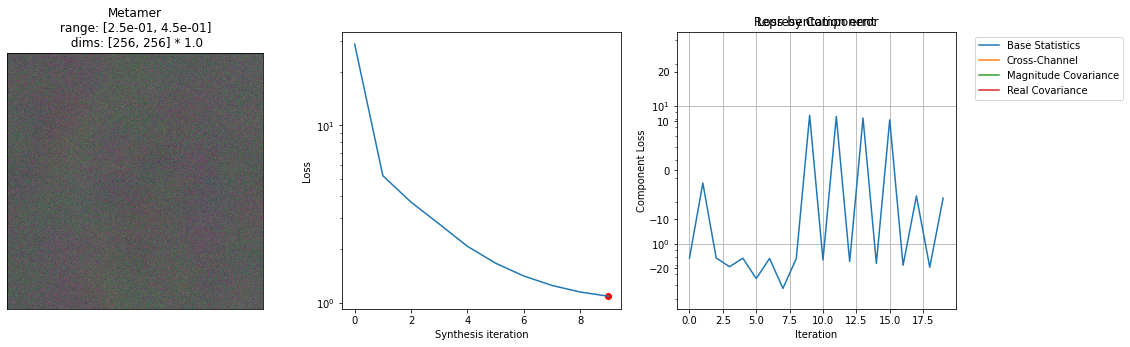

In [76]:
met = DetailedMetamerCTF(
    image=img[None, :, :, :],
    model=model,
    initial_image=torch.rand_like(img[None, :, :, :]) * 0.01 + img.mean(),
    coarse_to_fine="together",
)

met.synthesize(
    max_iter=long_synth_max_iter,
    store_progress=True,
    change_scale_criterion=None,
    ctf_iters_to_check=4,
)

plot_detailed_synthesis_status(met, plot_representation_error_as_rgb=True)

### back to old analysis

In [40]:
# convert the metamers to a tensor
metamers_opc_tensor = torch.stack([metamer.metamer for metamer in metamers_opc], dim=0)
# drop the first dimension of the tensor
metamers_opc_tensor = metamers_opc_tensor.squeeze(1)
metamers_opc_tensor.shape

torch.Size([1, 3, 256, 256])

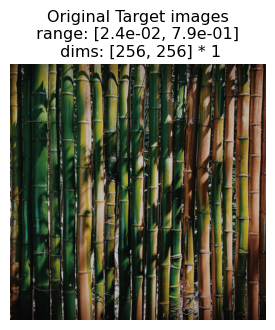

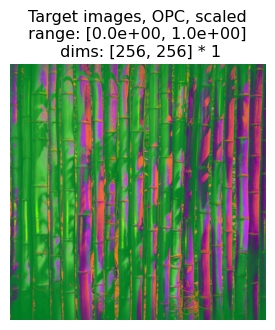

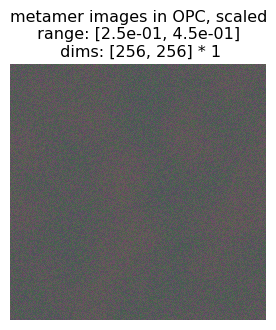

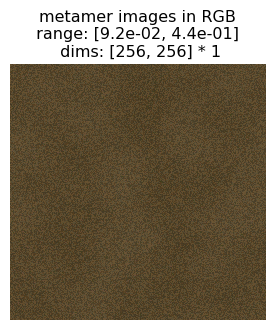

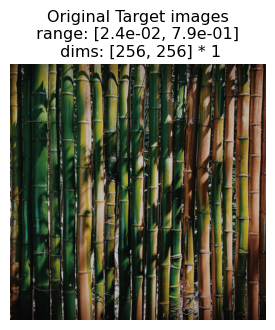

In [41]:
# print opc metamer images and target images
po.imshow(
    [metamer.image for metamer in metamers_opc],
    title="Target images, OPC, scaled",
    as_rgb=True,
)
# save the metamer images

# save original / target images
torchvision.utils.save_image(
    img_tensor[0:nth_img], "../../../ceph/experiments/bw_target_images.png", nrow=6
)
po.imshow(metamers_opc_tensor, title="metamer images in OPC, scaled", as_rgb=True)

# inverse rescale metamer opc images
metamers_opc_tensor_inverse_rescaled = img_transforms.inverse_rescale(
    metamers_opc_tensor, min_val[:nth_img], max_val[:nth_img]
)
# compute the rgb metamer images
opc2rgb = img_transforms.opc2rgb.to(DEVICE)

# convert the metamer images to rgb
# and save them
# Create the filename using an f-string
filename = f"bw_iter-{iter}_scale_ch_covar-{scale_ch_covar}_scale_ch_mag-{scale_ch_mag}_scale_ch_real-{scale_ch_real}_metamer_rgb.png"
file_path = op.join("../../../ceph/experiments/", filename)
metamers_rgb_tensor = img_transforms.color_transform_image(
    metamers_opc_tensor_inverse_rescaled, opc2rgb
)
torchvision.utils.save_image(metamers_rgb_tensor, file_path, nrow=6)
# print the rgb metamer images
po.imshow(metamers_rgb_tensor, title="metamer images in RGB", as_rgb=True)
# print the original image
po.imshow(img_tensor, title="Original Target images", as_rgb=True)

magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
magnitude pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 256, 256])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 128, 128])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 64, 64])
requires grad cross channel: True
real pyramid coefficient shape: torch.Size([1, 3, 4, 32, 32])
requires grad cross channel: True
base representation shape: torch.Size([1, 3, 1046]), cross channel stats shape: torch.Size([1, 3, 3]),
 cross channel mag covar shape: torch.Size([1, 3, 12]),
 cross channel real covar shape: torch.Size([

/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/display.py:1024: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


(<Figure size 1224x360 with 4 Axes>,
 {'display_metamer': 0,
  'plot_loss': 1,
  'plot_representation_error': [3, 2],
  'misc': []})

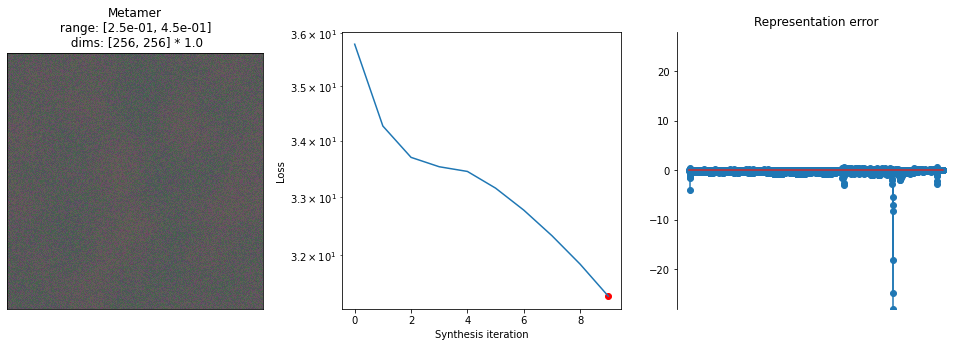

In [50]:
# po.synth.metamer.plot_synthesis_status(met, split_loss_channels=True)
po.synth.metamer.plot_synthesis_status(met, plot_representation_error_as_rgb=True)

## Run color model on Grayscale images


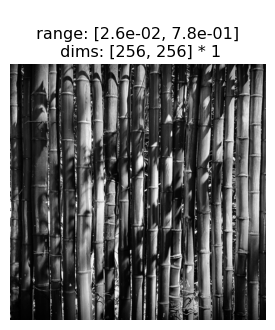

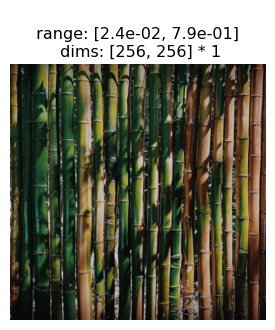

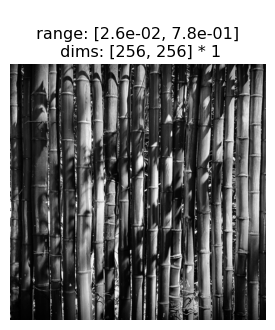

In [45]:
# turn image tensor into grayscale images
po.imshow(img_tensor, as_rgb=True)
# Define the Grayscale transform
grayscale_transform = transforms.Grayscale(num_output_channels=1)

img_tensor_gray = grayscale_transform(img_tensor)
# print the grayscale images
po.imshow(img_tensor_gray, as_rgb=False)

/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/validate.py:197: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(
/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/validate.py:232: UserWarning: Validating whether model can work with coarse-to-fine synthesis -- this can take a while!
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

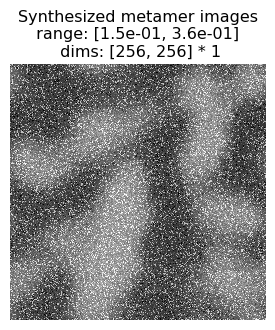

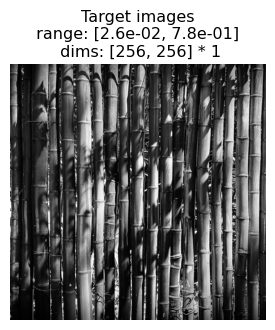

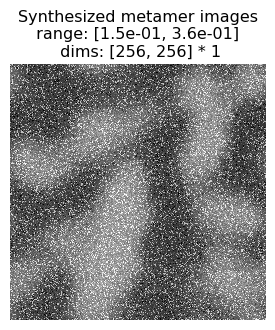

In [46]:
# for each image, run synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img_tensor_gray.shape[-2:]).to(DEVICE)
metamers = []
for i in range(img_tensor_gray.shape[0]):
    # metamer = run_synthesis(img_tensor_gray[i:i+1], model)
    metamer = run_synthesis(
        img_tensor_gray[i : i + 1], model, loss_function=po.tools.optim.l2_norm
    )
    metamers.append(metamer)
# print the metamer images
po.imshow([metamer.image for metamer in metamers], title="Target images", as_rgb=False)
# print target image
po.imshow(
    [metamer.metamer for metamer in metamers],
    title="Synthesized metamer images",
    as_rgb=False,
)